In [1]:
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-06-14 03:39:10.598180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749872350.755887      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749872350.796778      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
DS_PATH = '/kaggle/input/english-to-hindi-parallel-dataset/newdata.csv'
SOS = '<sos>'
EOS = '<eos>'
UNK = '<unk>'

In [3]:
data = pd.read_csv(DS_PATH, nrows=80000)
data.head()

,Unnamed: 0,english_sentence,hindi_sentence
0,0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [4]:
data = data[['english_sentence', 'hindi_sentence']]
data.columns = ['english', 'hindi']
data = data.dropna()
data.head()

,english,hindi
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [5]:
eng_tokenizer = Tokenizer(num_words=40000, oov_token=UNK)
eng_tokenizer.fit_on_texts(data['english'])
eng_sequences = eng_tokenizer.texts_to_sequences(data['english'])

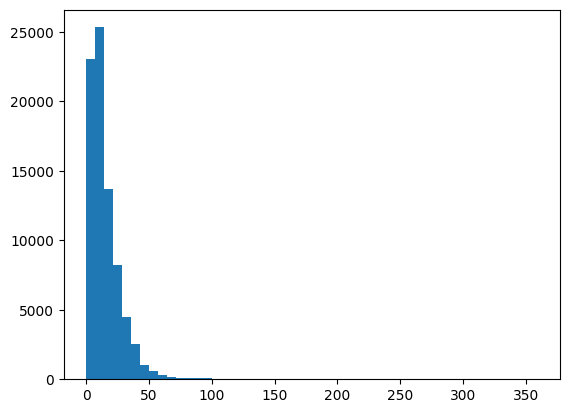

In [6]:
eng_lengths = [len(seq) for seq in eng_sequences]
plt.hist(eng_lengths, bins=50)
plt.show()

In [7]:
eng_max_len = 100
eng_padded = pad_sequences(eng_sequences, maxlen=eng_max_len, padding='post', truncating='post')

In [8]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'

hindi_tokenizer = Tokenizer(num_words=40000, oov_token=UNK, filters=filters)
hindi_tokenizer.fit_on_texts([f"{SOS} {x} {EOS}" for x in data['hindi']])

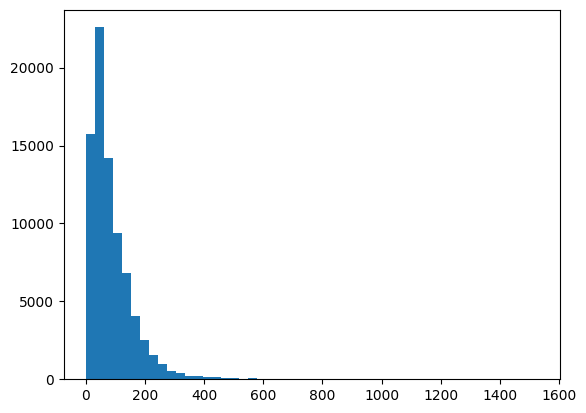

In [9]:
hindi_lengths = [len(sen) for sen in data['hindi']]
plt.hist(hindi_lengths, bins=50)
plt.show()

In [10]:
hindi_max_len = 300

def process_hindi_sentence(text):
    tokens = hindi_tokenizer.texts_to_sequences([f"{SOS} {text} {EOS}"])[0]

    padded = pad_sequences([tokens], maxlen=hindi_max_len, padding='post', truncating='post')[0]

    if len(tokens) >= hindi_max_len:
        padded[-1] = hindi_tokenizer.word_index[EOS]

    return padded

hindi_padded = np.array([process_hindi_sentence(x) for x in data['hindi']])

In [11]:
decoder_input = hindi_padded[:, :-1]
decoder_output = hindi_padded[:, 1:]

In [12]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
hindi_vocab_size = len(hindi_tokenizer.word_index) + 1

In [13]:
with open("eng_tokenizer.pkl", "wb") as f:
    pickle.dump(eng_tokenizer, f)

with open("hindi_tokenizer.pkl", "wb") as f:
    pickle.dump(hindi_tokenizer, f)

In [14]:
latent_dim = 440

In [15]:
config = {
    "eng_max_len": eng_max_len,
    "hindi_max_len": hindi_max_len,
    "latent_dim": latent_dim,
    "eng_vocab_size": eng_vocab_size,
    "hindi_vocab_size": hindi_vocab_size
}

with open("config.json", "w") as f:
    json.dump(config, f)

In [16]:
encoder_inputs = Input(shape=(None,))
encoder_embedding_layer = Embedding(eng_vocab_size, latent_dim)
encoder_embeddings = encoder_embedding_layer(encoder_inputs)

encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embeddings)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(hindi_vocab_size, latent_dim)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_state=True, return_sequences=True)
decoder_out_seqs, _, _ = decoder_lstm(decoder_embeddings, initial_state=encoder_states)

decoder_dense = Dense(hindi_vocab_size, activation="softmax")
decoder_outputs = decoder_dense(decoder_out_seqs)

model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1749872371.821975      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749872371.822577      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint_callback = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

In [18]:
history = model.fit([eng_padded, decoder_input],
    decoder_output.reshape(decoder_output.shape[0], decoder_output.shape[1], 1),
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint_callback]
)

Epoch 1/20


I0000 00:00:1749872378.004059      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.9414 - loss: 0.6031
Epoch 1: saving model to model_epoch_01.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2616s 653ms/step - accuracy: 0.9414 - loss: 0.6030 - val_accuracy: 0.9496 - val_loss: 0.3547
Epoch 2/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.9498 - loss: 0.3412
Epoch 2: saving model to model_epoch_02.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2653s 663ms/step - accuracy: 0.9498 - loss: 0.3412 - val_accuracy: 0.9523 - val_loss: 0.3140
Epoch 3/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9538 - loss: 0.2848
Epoch 3: saving model to model_epoch_03.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2661s 665ms/step - accuracy: 0.9538 - loss: 0.2848 - val_accuracy: 0.9545 - val_loss: 0.2915
Epoch 4/20
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.9574 - loss: 0.2434
Epoch 4: saving model to model_epoch_04.keras
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 2662s 665ms/step - accuracy: 0.9574 - loss: 0.2434 - val_accurac

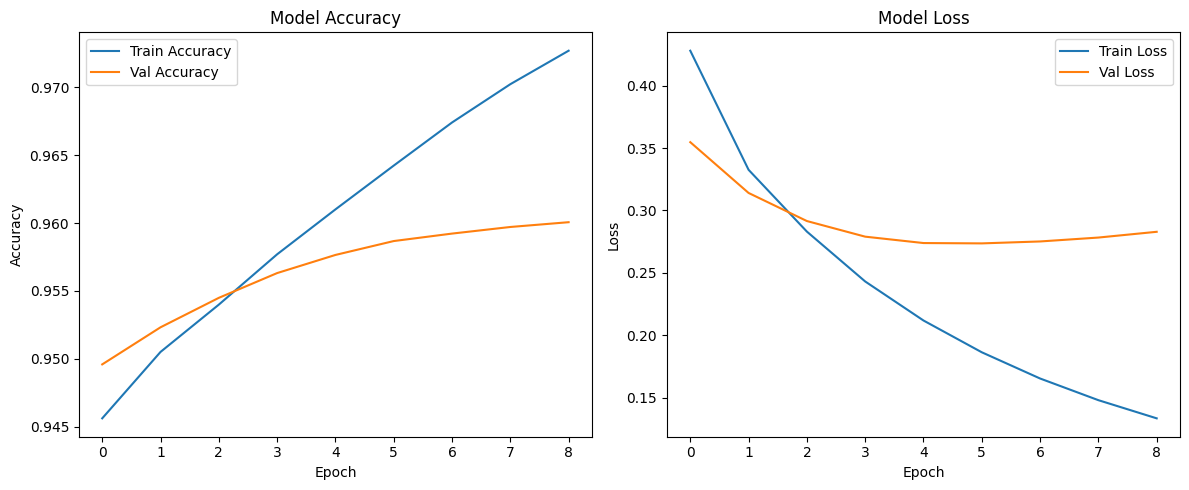

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
model.save("eng_hindi_translator.keras")

In [22]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/model_epoch_06.keras')

# ***Inference***

In [23]:
encoder_model = Model(encoder_inputs, encoder_states)

In [24]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_emb2 = decoder_embedding_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    decoder_emb2, initial_state=decoder_states_inputs
)

decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [25]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.array([[hindi_tokenizer.word_index['<sos>']]])

    decoded_sentence = ''
    stop_condition = False

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=False)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = hindi_tokenizer.index_word.get(sampled_token_index, '<unk>')

        if sampled_word == '<eos>' or len(decoded_sentence.split()) > hindi_max_len:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word

        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return decoded_sentence.strip()

In [26]:
test_sentence = "thank you"
test_seq = eng_tokenizer.texts_to_sequences([test_sentence.lower()])
test_seq = pad_sequences(test_seq, maxlen=eng_max_len, padding='post')

translated = decode_sequence(test_seq)
print("English:", test_sentence)
print("Hindi:", translated)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
English: thank you
Hindi: धन्यवाद


In [27]:
test_sentence = "See this also"
test_seq = eng_tokenizer.texts_to_sequences([test_sentence.lower()])
test_seq = pad_sequences(test_seq, maxlen=eng_max_len, padding='post')

translated = decode_sequence(test_seq)
print("English:", test_sentence)
print("Hindi:", translated)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
English: See this also
Hindi: यह भी देखें
